In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta, timezone
from pathlib import Path

# --- CONFIGURATION ---
RAW_DIR = Path("../data/raw/val")
RECON_DIR = Path("../data/reconstructions/validation")
OUTPUT_DIR = Path("../reports/figures")

# VISUALIZATION SETTINGS
DOWNSAMPLE_FACTOR = 10  # Keep every 10th time sample (prevent RAM crash)
FIG_SIZE = (20, 14)     # Big landscape plot

def get_file_metadata(path):
    """Extracts timestamp and physics parameters from HDF5."""
    with h5py.File(path, 'r') as f:
        # Get Unix timestamp (seconds since epoch)
        t0 = f['header/time'][()]
        dt = f['header/dt'][()]
        dx = f['header/dx'][()]
        shape = f['data'].shape
    return t0, dt, dx, shape

def load_and_stitch_with_time(raw_path, recon_path):
    """
    Loads all files, downsamples them, and builds a continuous Datetime axis.
    """
    # 1. Match Files
    raw_files = sorted(list(raw_path.glob("*.h5")) + list(raw_path.glob("*.hdf5")))
    recon_files = sorted(list(recon_path.glob("residual_*.h5")) + list(recon_path.glob("residual_*.hdf5")))
    
    full_raw = []
    full_res = []
    
    # We need to build the time axis relative to the very first file
    start_timestamp = None
    total_samples = 0
    current_dt = 0.0
    current_dx = 0.0

    print(f"Stitching {len(recon_files)} files...")
    
    for res_file in recon_files:
        orig_name = res_file.name.replace("residual_", "")
        # Find matching raw file
        raw_file = next((p for p in raw_files if p.name == orig_name), None)
        
        if not raw_file:
            continue
            
        try:
            # Get Metadata
            t0, dt, dx, shape = get_file_metadata(raw_file)
            
            # Capture global parameters from the first file
            if start_timestamp is None:
                start_timestamp = t0
                current_dt = dt
                current_dx = dx
            
            # Load Data (Downsampled)
            with h5py.File(raw_file, 'r') as f_raw, h5py.File(res_file, 'r') as f_res:
                
                # RAW: Read direct -> Float32 -> Downsample -> Absolute Value
                r_data = np.empty(shape, dtype=np.float32)
                f_raw['data'].read_direct(r_data)
                
                # CRITICAL CHANGE 1: Use Energy (Abs) instead of Amplitude
                r_down = np.abs(r_data[::DOWNSAMPLE_FACTOR, :])
                full_raw.append(r_down)

                # RESIDUAL: Load -> Downsample
                res_data = f_res['data'][:] 
                res_down = res_data[::DOWNSAMPLE_FACTOR, :]
                full_res.append(res_down)
                
                total_samples += r_down.shape[0]

        except Exception as e:
            print(f"Error reading {res_file.name}: {e}")

    # Stack Arrays
    if not full_raw:
        raise ValueError("No data loaded!")

    big_raw = np.vstack(full_raw)
    big_res = np.vstack(full_res)
    
    # Build Real-World Time Axis
    # Start Date
    start_datetime = datetime.fromtimestamp(start_timestamp, tz=timezone.utc)
    
    # Duration of the FULL stitched stack
    # Effective dt is larger because we downsampled
    effective_dt = current_dt * DOWNSAMPLE_FACTOR
    duration_sec = total_samples * effective_dt
    end_datetime = start_datetime + timedelta(seconds=duration_sec)
    
    return big_raw, big_res, start_datetime, end_datetime, current_dx

def plot_smart_waterfall(raw, res, t_start, t_end, dx):
    """
    Plots Raw vs Residual with Real-World Time and Smart Contrast.
    """
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    # Dimensions
    max_dist_km = raw.shape[1] * dx / 1000.0
    
    # Convert datetimes to Matplotlib numbers for plotting
    t_start_num = mdates.date2num(t_start)
    t_end_num = mdates.date2num(t_end)
    
    # EXTENT: [left, right, bottom, top]
    # We want Earliest Time (t_start) at the BOTTOM.
    extent = [0, max_dist_km, t_start_num, t_end_num]

    # CRITICAL CHANGE 2: Smart Contrast (Percentile)
    # This ignores the crazy loud pops and focuses on the ship/noise
    vmax_raw = np.percentile(raw, 99.5)  # Clip top 0.5% outliers
    vmax_res = np.percentile(res, 99.5)

    print(f"Plotting... Raw Vmax: {vmax_raw:.4f}, Res Vmax: {vmax_res:.4f}")

    fig, axs = plt.subplots(2, 1, figsize=FIG_SIZE, sharex=True, sharey=True)
    
    # --- PLOT 1: RAW ENERGY (JET CMAP) ---
    # origin='lower' puts the first data row at the bottom (matching t_start)
    im0 = axs[0].imshow(raw, aspect='auto', cmap='jet', origin='lower',
                        extent=extent, vmin=0, vmax=vmax_raw)
    
    axs[0].set_title(f"Raw DAS Energy (Start: {t_start.strftime('%H:%M:%S')} UTC)", fontsize=16)
    axs[0].set_ylabel("Time (UTC)", fontsize=14)
    
    # Format Y-Axis as HH:MM:SS
    axs[0].yaxis_date()
    axs[0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    cbar0 = plt.colorbar(im0, ax=axs[0], pad=0.02)
    cbar0.set_label("|Strain Rate|")

    # --- PLOT 2: ANOMALY RESIDUAL ---
    # Using 'inferno' to make the anomaly burn bright against black
    im1 = axs[1].imshow(res, aspect='auto', cmap='inferno', origin='lower',
                        extent=extent, vmin=0, vmax=vmax_res)
    
    axs[1].set_title("Anomaly Detection (Residuals)", fontsize=16)
    axs[1].set_xlabel("Distance (km)", fontsize=14)
    axs[1].set_ylabel("Time (UTC)", fontsize=14)
    
    cbar1 = plt.colorbar(im1, ax=axs[1], pad=0.02)
    cbar1.set_label("Reconstruction Error")

    plt.tight_layout()
    
    save_path = OUTPUT_DIR / "final_trajectory_analysis_validation.png"
    plt.savefig(save_path, dpi=300)
    print(f"✅ Saved Analysis to {save_path}")

if __name__ == "__main__":
    raw_arr, res_arr, t0, t1, dx = load_and_stitch_with_time(RAW_DIR, RECON_DIR)
    if len(raw_arr) > 0:
        plot_smart_waterfall(raw_arr, res_arr, t0, t1, dx)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\45422\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\45422\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "c:\Users\45422\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", 

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

Stitching 37 files with T-downsample=10 and X-downsample=4...
Plotting Array Shape: (29600, 3906) (Distance: 63.8 km)
✅ Saved Final Analysis to ..\reports\figures\final_formal_analysis.png


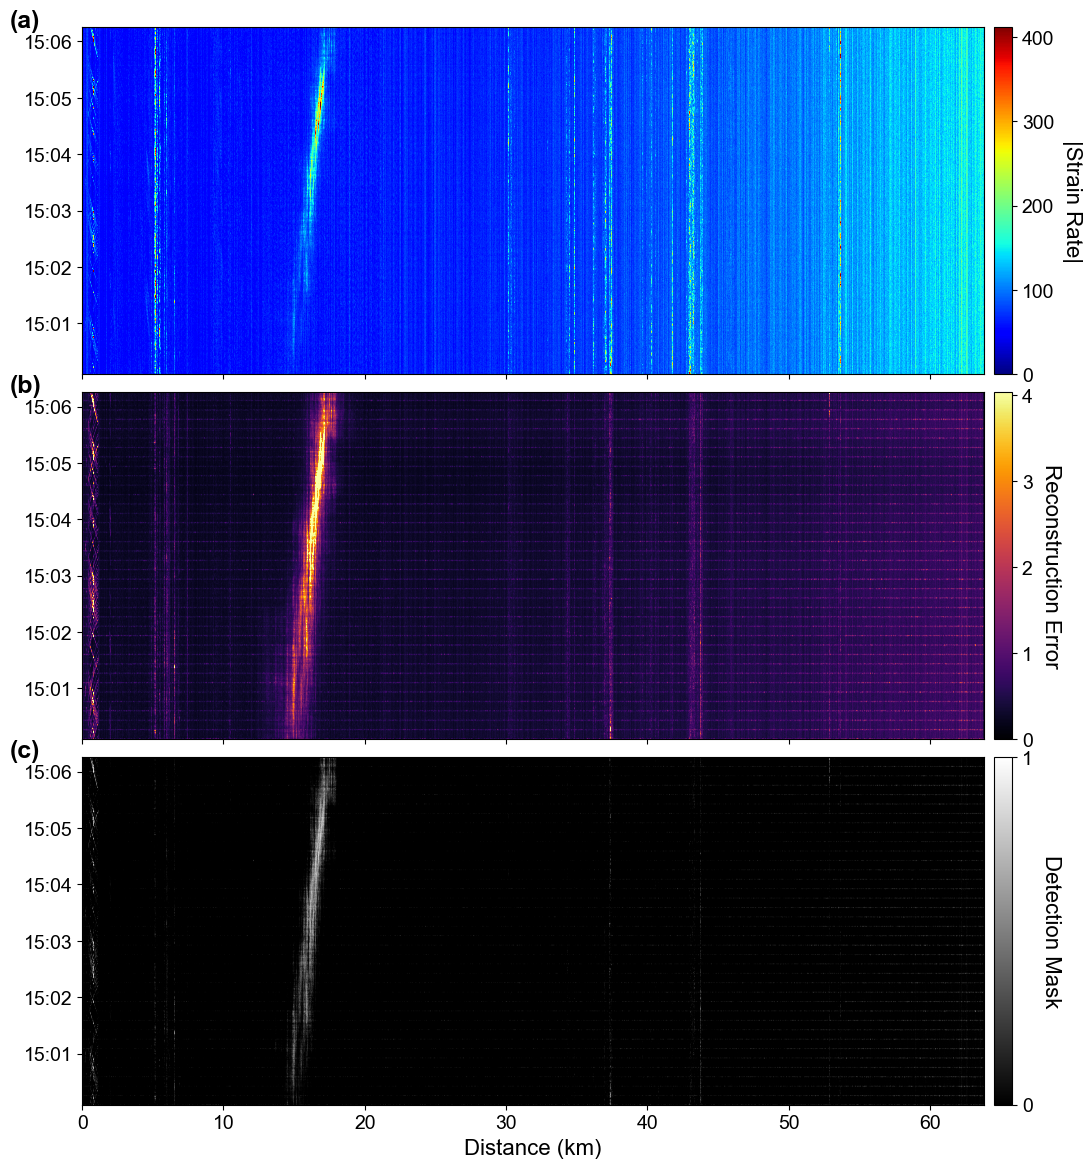

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime, timedelta, timezone
from pathlib import Path

# --- CONFIGURATION ---
RAW_DIR = Path("../data/raw/inference")
RECON_DIR = Path("../data/reconstructions")
OUTPUT_DIR = Path("../reports/figures")

# VISUALIZATION SETTINGS
TIME_DOWNSAMPLE = 10    # Keep every 10th time sample
SPATIAL_DOWNSAMPLE = 4  # Keep every 4th spatial point (CRITICAL FOR MEMORY)
FIG_SIZE = (12, 14)     
THRESHOLD = 3         

# FORMALIA
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans']
})

def get_file_metadata(path):
    with h5py.File(path, 'r') as f:
        t0 = f['header/time'][()]
        dt = f['header/dt'][()]
        dx = f['header/dx'][()]
        shape = f['data'].shape
    return t0, dt, dx, shape

def load_and_stitch_optimized(raw_path, recon_path):
    raw_files = sorted(list(raw_path.glob("*.h5")) + list(raw_path.glob("*.hdf5")))
    recon_files = sorted(list(recon_path.glob("residual_*.h5")) + list(recon_path.glob("residual_*.hdf5")))
    
    full_raw = []
    full_res = []
    
    start_timestamp = None
    total_time_samples = 0
    current_dt = 0.0
    current_dx = 0.0

    print(f"Stitching {len(recon_files)} files with T-downsample={TIME_DOWNSAMPLE} and X-downsample={SPATIAL_DOWNSAMPLE}...")
    
    for res_file in recon_files:
        orig_name = res_file.name.replace("residual_", "")
        raw_file = next((p for p in raw_files if p.name == orig_name), None)
        
        if not raw_file: continue
            
        try:
            t0, dt, dx, shape = get_file_metadata(raw_file)
            
            if start_timestamp is None:
                start_timestamp = t0
                current_dt = dt
                current_dx = dx
            
            with h5py.File(raw_file, 'r') as f_raw, h5py.File(res_file, 'r') as f_res:
                # --- OPTIMIZATION: Slice immediately on load ---
                # We read only what we need. 
                # Note: h5py supports slicing directly from disk if dataset is chunked, 
                # but reading full then slicing is often safer for random formats.
                
                # Load Raw
                r_data = np.empty(shape, dtype=np.float32)
                f_raw['data'].read_direct(r_data)
                # Apply BOTH time and spatial downsampling
                r_down = np.abs(r_data[::TIME_DOWNSAMPLE, ::SPATIAL_DOWNSAMPLE])
                full_raw.append(r_down)

                # Load Residual
                res_data = f_res['data'][:] 
                res_down = res_data[::TIME_DOWNSAMPLE, ::SPATIAL_DOWNSAMPLE]
                full_res.append(res_down)
                
                total_time_samples += r_down.shape[0]

        except Exception as e:
            print(f"Error reading {res_file.name}: {e}")

    if not full_raw:
        raise ValueError("No data loaded!")

    big_raw = np.vstack(full_raw)
    big_res = np.vstack(full_res)
    
    # Recalculate physical params based on downsampling
    start_datetime = datetime.fromtimestamp(start_timestamp, tz=timezone.utc)
    
    # Effective dt increases because we skip time samples
    effective_dt = current_dt * TIME_DOWNSAMPLE
    duration_sec = total_time_samples * effective_dt
    end_datetime = start_datetime + timedelta(seconds=duration_sec)
    
    # Effective dx increases because we skip spatial samples
    # We ALSO apply your requested 4x scaling factor here
    effective_dx = (current_dx * 4) * SPATIAL_DOWNSAMPLE
    
    return big_raw, big_res, start_datetime, end_datetime, effective_dx

def add_formal_colorbar(im, ax, label, ticks=None):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label, rotation=270, labelpad=20)
    if ticks is not None: cbar.set_ticks(ticks)
    return cbar

def plot_final_waterfall(raw, res, t_start, t_end, dx):
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    # --- MEMORY FIX 2: Use uint8 (1 byte) instead of int64 (8 bytes) ---
    binary_map = (res > THRESHOLD).astype(np.uint8)
    
    vmax_raw = np.percentile(raw, 99.5)
    vmax_res = np.percentile(res, 99.5)

    # Calculate Max Distance
    # dx is already "effective_dx" from the load function
    max_dist_km = (raw.shape[1] * dx) / 1000.0
    
    t_start_num = mdates.date2num(t_start)
    t_end_num = mdates.date2num(t_end)
    extent = [0, max_dist_km, t_start_num, t_end_num]

    print(f"Plotting Array Shape: {raw.shape} (Distance: {max_dist_km:.1f} km)")

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=FIG_SIZE, sharex=True)
    plt.subplots_adjust(hspace=0.05)
    date_fmt = mdates.DateFormatter('%H:%M')

    # (a) RAW
    im1 = ax1.imshow(raw, aspect='auto', cmap='jet', origin='lower', extent=extent, vmin=0, vmax=vmax_raw)
    add_formal_colorbar(im1, ax1, '|Strain Rate|')
    ax1.yaxis_date()
    ax1.yaxis.set_major_formatter(date_fmt)
    ax1.text(-0.08, 1.05, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', va='top')

    # (b) ERROR
    im2 = ax2.imshow(res, aspect='auto', cmap='inferno', origin='lower', extent=extent, vmin=0, vmax=vmax_res)
    add_formal_colorbar(im2, ax2, 'Reconstruction Error')
    ax2.yaxis_date()
    ax2.yaxis.set_major_formatter(date_fmt)
    ax2.text(-0.08, 1.05, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', va='top')

    # (c) MASK
    im3 = ax3.imshow(binary_map, aspect='auto', cmap='gray', origin='lower', extent=extent, vmin=0, vmax=1)
    add_formal_colorbar(im3, ax3, 'Detection Mask', ticks=[0, 1])
    ax3.yaxis_date()
    ax3.yaxis.set_major_formatter(date_fmt)
    ax3.text(-0.08, 1.05, '(c)', transform=ax3.transAxes, fontsize=18, fontweight='bold', va='top')
    
    ax3.set_xlabel("Distance (km)")

    save_path = OUTPUT_DIR / "final_formal_analysis.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved Final Analysis to {save_path}")

if __name__ == "__main__":
    raw_arr, res_arr, t0, t1, dx = load_and_stitch_optimized(RAW_DIR, RECON_DIR)
    if len(raw_arr) > 0:
        plot_final_waterfall(raw_arr, res_arr, t0, t1, dx)